In [ ]:
# !cp /content/drive/MyDrive/Portfolio/image_caption/Data/* .

Ref:
- https://www.youtube.com/watch?v=y2BaTt1fxJU
- https://youtu.be/fUSTbGrL1tc


# Download Dataset



- ref : https://www.kaggle.com/datasets/adityajn105/flickr8k

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chiragpatil","key":"b966d962e0371906b83e9bb931ebd7e7"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [01:05<00:00, 17.7MB/s]
100% 1.04G/1.04G [01:05<00:00, 17.0MB/s]


In [ ]:
!unzip flickr8k.zip

# Imports

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg_preprocessor
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocessor
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as efficientnetB0_preprocessor
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense, LSTM, Dropout,add,Embedding
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random
import pickle
import re

# Explore and split data into train test split

In [ ]:
captions_df = pd.read_csv("/content/captions.txt",sep=",")

In [ ]:
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
print("total captions : ",captions_df.shape[0])

total captions :  40455


In [ ]:
total_images = len(os.listdir("Images"))
print("total images : ",total_images)

total images :  8091


- Here we can observe that for one image we have multiple captions, hence captions are more than number of images.
- We can say that for one image we have approax 5 captions.

## split data

- we split images into train and test, based on image name we will extract all captions of that image in corrseponding set

In [ ]:
all_images = os.listdir("Images")

In [ ]:
# select training image
training_images = random.sample(all_images,int(total_images*0.8))
test_images = list(set(all_images) - set(training_images))

In [ ]:
print("num of train_images : ", len(training_images))
print("num of test_images : ", len(test_images))

num of train_images :  6472
num of test_images :  1619


In [ ]:
train_df = captions_df.loc[captions_df['image'].isin(training_images)]
test_df = captions_df.loc[captions_df['image'].isin(test_images)]

In [ ]:
print("train_df shape", train_df.shape)
print("test_df shape", test_df.shape)

train_df shape (32360, 2)
test_df shape (8095, 2)


In [ ]:
train_df.to_excel("train_df.xlsx",index=False)
test_df.to_excel("test_df.xlsx",index=False)

# Extract image feature from pretrained model 

In [ ]:
train_df = pd.read_excel("train_df.xlsx")
test_df = pd.read_excel("test_df.xlsx")

In [ ]:
image_folder_name = "Images"

In [ ]:
def get_features(df,model,preprocessor,image_folder_name,target_size=(224,224)):
    feature_dict = {}
    for image_name in tqdm(df['image'].unique()):

        # load image 
        img = image.load_img(os.path.join(image_folder_name,image_name),
                            target_size=target_size
                            )
        # convert image into array
        img = image.img_to_array(img)

        # expand one dimention , for passing into model
        # (224,224,3) -> (1,224,224,3)
        img = tf.expand_dims(img,axis=0)

        # preprocess image for model
        img = preprocessor(img)

        # extract feature vector
        feature_vector = model.predict(img,verbose=0)

        # store feature vector into dict
        feature_dict[image_name] = feature_vector

    return feature_dict


## VGG19

In [ ]:
vgg_19_feature_extractor = VGG19()
vgg_19_feature_extractor = Model(inputs=vgg_19_feature_extractor.inputs,
                                 outputs=vgg_19_feature_extractor.layers[-2].output)


574710816/574710816 [==============================] - 27s 0us/step


In [ ]:
vgg19_train_features = get_features(train_df,
                                   vgg_19_feature_extractor,
                                    vgg_preprocessor,
                                   image_folder_name,
                                   )

100%|██████████| 6472/6472 [08:41<00:00, 12.41it/s]


In [ ]:
len(vgg19_train_features)

6472

In [ ]:
with open('/content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/vgg19_train_features.pickle', 'wb') as handle:
    pickle.dump(vgg19_train_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
vgg19_test_features = get_features(test_df,
                                   vgg_19_feature_extractor,
                                    vgg_preprocessor,
                                   image_folder_name,
                                   )

100%|██████████| 1619/1619 [02:09<00:00, 12.47it/s]


In [ ]:
with open('/content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/vgg19_test_features.pickle', 'wb') as handle:
    pickle.dump(vgg19_test_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

## ResNet50

In [ ]:
resnet50_feature_extractor = ResNet50()
resnet50_feature_extractor = Model(inputs=resnet50_feature_extractor.inputs,
                                 outputs=resnet50_feature_extractor.layers[-2].output)


102967424/102967424 [==============================] - 6s 0us/step


In [ ]:
resnet50_train_features = get_features(train_df,
                                   resnet50_feature_extractor,
                                   resnet_preprocessor,
                                   image_folder_name,
                                   )

100%|██████████| 6472/6472 [08:28<00:00, 12.72it/s]


In [ ]:
with open('/content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/resnet50_train_features.pickle', 'wb') as handle:
    pickle.dump(resnet50_train_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
resnet50_test_features = get_features(test_df,
                                   resnet50_feature_extractor,
                                   resnet_preprocessor,
                                   image_folder_name,
                                   )

100%|██████████| 1619/1619 [02:08<00:00, 12.62it/s]


In [ ]:
with open('/content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/resnet50_test_features.pickle', 'wb') as handle:
    pickle.dump(resnet50_test_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

## EfficientNetB0

In [ ]:
efficientNet_B0_feature_extractor = EfficientNetB0()
efficientNet_B0_feature_extractor = Model(inputs=efficientNet_B0_feature_extractor.inputs,
                                          outputs=efficientNet_B0_feature_extractor.layers[-2].output
                                          )


21834768/21834768 [==============================] - 2s 0us/step


In [ ]:
efficientNet_B0_train_features = get_features(train_df,
                                              efficientNet_B0_feature_extractor,
                                              efficientnetB0_preprocessor,
                                              image_folder_name,
                                              )

100%|██████████| 6472/6472 [08:18<00:00, 12.98it/s]


In [ ]:
with open('/content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/efficientNet_B0_train_features.pickle', 'wb') as handle:
    pickle.dump(efficientNet_B0_train_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
efficientNet_B0_test_features = get_features(test_df,
                                              efficientNet_B0_feature_extractor,
                                              efficientnetB0_preprocessor,
                                              image_folder_name,
                                              )

100%|██████████| 1619/1619 [02:03<00:00, 13.15it/s]


In [ ]:
with open('/content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/efficientNet_B0_test_features.pickle', 'wb') as handle:
    pickle.dump(efficientNet_B0_test_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

# pre-process captions

In [ ]:
start_token = "<start>"
end_token = "<end>"

# match all of the characters except the alphabets
except_alpha_re = re.compile("[^A-Za-z]")

# match multiple space
spce_re = re.compile("\s+")

def text_preprocess(text):

    # remove starting and ending spaces
    text = text.strip()

    # convert into lowercase
    text = text.lower()

    # remove number special chars etc.. (remove everything except A-Za-z)
    text = except_alpha_re.sub(" ",text)

    # caption must have atleast one word
    if len(text.strip()) > 1:
        
        # append start and end token
        text = start_token + " " + text + " " + end_token

        # remove multiple spaces with single space
        text = spce_re.sub(" ",text)

        return text
    
    return None


In [ ]:
train_df = pd.read_excel("train_df.xlsx")
test_df = pd.read_excel("test_df.xlsx")

In [ ]:
# remove nan
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
train_df['preprocessed_caption'] = train_df['caption'].apply(text_preprocess)
test_df['preprocessed_caption'] = test_df['caption'].apply(text_preprocess)

In [ ]:
# remove nan
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
train_df.to_excel("/content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/train_df_processed.xlsx",index=False)
test_df.to_excel("/content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/test_df_processed.xlsx",index=False)

In [ ]:
train_df.preprocessed_caption.str.split(" ", expand=False).agg([len]).max()

len    38
dtype: int64

In [ ]:
train_df.preprocessed_caption.str.split(" ", expand=False).agg([len]).min()

len    4
dtype: int64

In [ ]:
max_len = 38

In [ ]:
oov_token = "<OOV>"
tokenizer = Tokenizer(filters="",oov_token=oov_token)
tokenizer.fit_on_texts(train_df['preprocessed_caption'])
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

7676

In [ ]:
vocab_size = 7676

In [ ]:
# saving tokenizer
with open('/content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Data generator

In [ ]:
!cp /content/drive/MyDrive/Portfolio/image_caption/8k_flicker/Data/* .

In [ ]:
# def data_generator(features,df,tokenizer,max_len,vocab_size,batch_size=32):
#     X1,X2,y = list(),list(),list()
#     n = 0
#     df = df.sample(frac=1).reset_index(drop=True)
#     while True:
#         for i,row in df.iterrows():
#             text = row['preprocessed_comment']
            
#             # convert string into sequence of number
#             seq = tokenizer.texts_to_sequences([text])[0]

#             # split sequence into X,y pair
#             # for example
#             # text = "<START> men playing football <END>"
#             # X                                       y
#             # <START>                                 men
#             # <START> men                             playing
#             # <START> men playing                     football
#             # <START> men playing footbal             <END>
           
#             for i in range(1,len(seq)):
               
#                 input_seq = seq[:i]
#                 output_seq = seq[i]

#                 # pad sequence to make all sequence as same length
#                 padded_input_seq = pad_sequences([input_seq],max_len,padding='post')[0]

#                 # convert output into categorial form
#                 output_seq = to_categorical([output_seq],vocab_size)[0]

#                 X1.append(features[ row['image_name']])[0]
#                 X2.append(padded_input_seq)
#                 y.append(output_seq)

#             if n == batch_size:
#                 X1, X2,y = np.array(X1),np.array(X2),np.array(y)
#                 yield [X1,X2],y
#                 X1,X2,y = list(),list(),list()
#                 n = 0



In [ ]:
# https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                 features,
                 df,
                 tokenizer,
                 max_len,
                 vocab_size,
                 batch_size=32,
                 shuffle=True):
        
        self.df = df.copy()
        self.features = features
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
       
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
   
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        X1,X2,y = list(),list(),list()

        for i,row in batches.iterrows():
            text = row['preprocessed_caption']
            
            # convert string into sequence of number
            seq = tokenizer.texts_to_sequences([text])[0]

            # split sequence into X,y pair
            # for example
            # text = "<START> men playing football <END>"
            # X                                       y
            # <START>                                 men
            # <START> men                             playing
            # <START> men playing                     football
            # <START> men playing footbal             <END>
           
            for i in range(1,len(seq)):
               
                input_seq = seq[:i]
                output_seq = seq[i]

                # pad sequence to make all sequence as same length
                padded_input_seq = pad_sequences([input_seq],max_len,padding='post')[0]

                # convert output into categorial form
                output_seq = to_categorical([output_seq],vocab_size)[0]

                X1.append(self.features[row['image']][0])
                X2.append(padded_input_seq)
                y.append(output_seq)

        X1, X2,y = np.array(X1),np.array(X2),np.array(y)
        return  [X1,X2], y
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
train_df = pd.read_excel("train_df_processed.xlsx")
test_df = pd.read_excel("test_df_processed.xlsx")

In [ ]:
tokenizer = pickle.load(open('tokenizer.pickle', 'rb'))

In [ ]:
max_len = 38
vocab_size = 7676

In [ ]:
index_to_words = {v:k for k,v in tokenizer.word_index.items()}
word_to_index = {v:k for k,v in index_to_words.items()}

def single_predict(model,img_features,tokenizer,max_len):
    initial_text = "<start>"

    for i in range(max_len):

        seq = tokenizer.texts_to_sequences([initial_text])[0]

        seq = pad_sequences([seq],max_len,padding="post")
        
        y_hat = model.predict([img_features,seq],verbose=0)

        y_hat = np.argmax(y_hat)

        pred_word = index_to_words.get(y_hat,None)

        if pred_word:
            initial_text = initial_text + " " + pred_word

        if pred_word == "<end>":
            return initial_text
    return initial_text

In [ ]:
end_token_index = word_to_index['<end>']
start_token_index = word_to_index['<start>']

def calculate_blue(y_true, y_pred):
    # remove <start> and <end> token
    y_true = y_true[:,1:-1]

    y_prediction_till_first_end = []
    for y in y_pred:
        end_index = tf.reduce_min(tf.where(y,end_token_index))
        y_prediction_till_first_end.append(y[:,end_index])
        




# model with VGG16 as feature extractor

In [ ]:
inp1 = Input(shape=(4096,))
dp1 = Dropout(0.2)(inp1)
fc = Dense(512,activation='relu')(dp1)

inp2 = Input(shape=(max_len,))
emb = Embedding(vocab_size,256,mask_zero=True)(inp2)
dp2 = Dropout(0.2)(emb)
seq = LSTM(512)(dp2)

# decoder
decoder = add([fc,seq])
decoder = Dense(512,activation='relu')(decoder)
output = Dense(vocab_size,activation='softmax')(decoder)

img_caption_model_vgg16 = Model(inputs=[inp1,inp2],outputs=output)
img_caption_model_vgg16.compile('adam',loss='categorical_crossentropy')

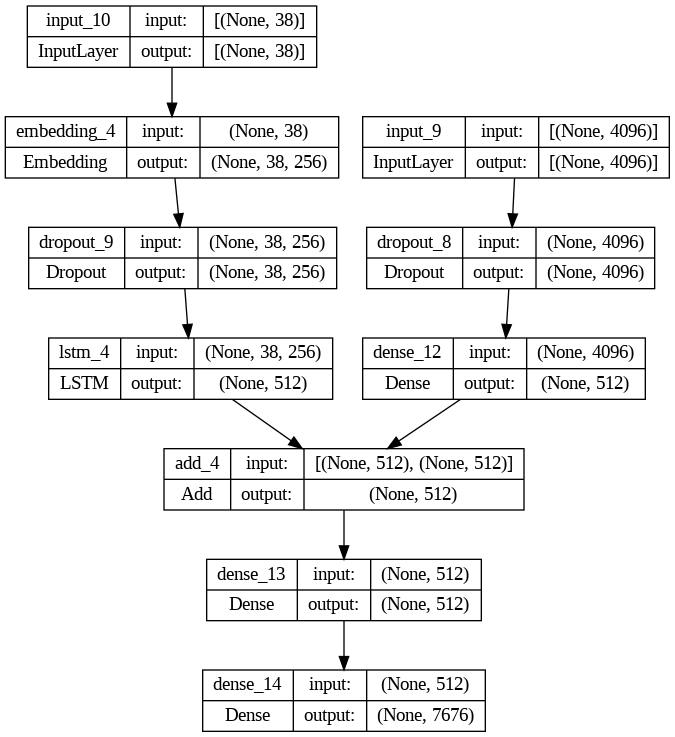

In [ ]:
plot_model(img_caption_model_vgg16,show_shapes=True)

## train_model

In [ ]:
batch_size = 64

train_vgg_feature = pickle.load(open("vgg19_train_features.pickle","rb"))

test_vgg_feature = pickle.load(open("vgg19_test_features.pickle","rb"))

In [ ]:
epoch = 100
train_steps = train_df.shape[0] // batch_size
test_steps = test_df.shape[0] // batch_size
checkpoint_path = "/content/vggcheckpoints/checkpoint"

train_generator = CustomDataGen(train_vgg_feature,
                                 train_df,
                                 tokenizer,
                                 max_len,
                                 vocab_size,
                                 batch_size
                                 )

test_generator = CustomDataGen(test_vgg_feature,
                                 test_df,
                                 tokenizer,
                                 max_len,
                                 vocab_size,
                                 batch_size
                                 )

early_stop_callback = EarlyStopping(patience=3,restore_best_weights=True)
# checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
#                                       save_weights_only=True,
#                                       save_best_only=True,
                                      
#                                       )

In [ ]:
history = img_caption_model_vgg16.fit(train_generator,
                                      validation_data = test_generator,
                                      epochs = epoch,
                                      batch_size = batch_size,
                                      steps_per_epoch= train_steps,
                                      validation_steps = test_steps,
                                      callbacks = [early_stop_callback,
                                                #    checkpoint_callback
                                                   ]
                                      )


Epoch 1/100
505/505 [==============================] - 68s 124ms/step - loss: 4.2624 - val_loss: 3.5759
Epoch 2/100
505/505 [==============================] - 58s 114ms/step - loss: 3.1493 - val_loss: 3.2673
Epoch 3/100
505/505 [==============================] - 51s 100ms/step - loss: 2.7335 - val_loss: 3.2461
Epoch 4/100
505/505 [==============================] - 53s 105ms/step - loss: 2.4489 - val_loss: 3.2788
Epoch 5/100
505/505 [==============================] - 51s 102ms/step - loss: 2.2374 - val_loss: 3.3645
Epoch 6/100
505/505 [==============================] - 54s 106ms/step - loss: 2.0713 - val_loss: 3.4322


In [ ]:
test_df['image'].unique()

array(['1001773457_577c3a7d70.jpg', '1007320043_627395c3d8.jpg',
       '1015584366_dfcec3c85a.jpg', ..., '977856234_0d9caee7b2.jpg',
       '99679241_adc853a5c0.jpg', '997722733_0cb5439472.jpg'],
      dtype=object)

In [ ]:
image_name = '1001773457_577c3a7d70.jpg'
single_predict(img_caption_model_vgg16,
               test_vgg_feature[image_name],
               tokenizer,
               max_len)

'<start> two dogs are playing with a ball <end>'

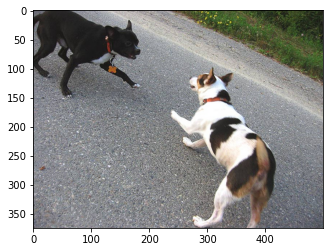

In [ ]:
img = Image.open("Images/"+image_name)
plt.imshow(img)

In [ ]:
img_caption_model_vgg16.save("img_caption_model_vgg16.h5")

# Model with resnet features

In [ ]:
batch_size = 128

tokenizer = pickle.load(open('tokenizer.pickle', 'rb'))

train_resnet_feature = pickle.load(open("resnet50_train_features.pickle","rb"))

test_resnet_feature = pickle.load(open("resnet50_test_features.pickle","rb"))

train_df = pd.read_excel("train_df_processed.xlsx")
test_df = pd.read_excel("test_df_processed.xlsx")


In [ ]:
inp1 = Input(shape=(2048,))
dp1 = Dropout(0.2)(inp1)
fc = Dense(512,activation='relu')(dp1)

inp2 = Input(shape=(max_len,))
emb = Embedding(vocab_size,256,mask_zero=True)(inp2)
dp2 = Dropout(0.2)(emb)
seq = LSTM(512)(dp2)

# decoder
decoder = add([fc,seq])
decoder = Dense(512,activation='relu')(decoder)
output = Dense(vocab_size,activation='softmax')(decoder)

img_caption_model_resnet50 = Model(inputs=[inp1,inp2],outputs=output)
img_caption_model_resnet50.compile('adam',loss='categorical_crossentropy')

In [ ]:
epoch = 100
train_steps = train_df.shape[0] // batch_size
test_steps = test_df.shape[0] // batch_size
checkpoint_path = "/content/drive/MyDrive/Portfolio/image_caption/resnet_checkpoints/checkpoints"

train_generator = CustomDataGen(train_resnet_feature,
                                 train_df,
                                 tokenizer,
                                 max_len,
                                 vocab_size,
                                 batch_size
                                 )

test_generator = CustomDataGen(test_resnet_feature,
                                 test_df,
                                 tokenizer,
                                 max_len,
                                 vocab_size,
                                 batch_size
                                 )

early_stop_callback = EarlyStopping(patience=5)
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=True
                                      )

In [ ]:
history = img_caption_model_resnet50.fit(train_generator,
                                      validation_data = test_generator,
                                      epochs = epoch,
                                      batch_size = batch_size,
                                      steps_per_epoch= train_steps,
                                      validation_steps = test_steps,
                                      callbacks = [early_stop_callback,
                                                   checkpoint_callback
                                                   ]
                                      )


Epoch 1/100
993/993 [==============================] - 433s 424ms/step - loss: 4.0545 - val_loss: 3.4901
Epoch 2/100
993/993 [==============================] - 392s 394ms/step - loss: 3.1914 - val_loss: 3.2594
Epoch 3/100
993/993 [==============================] - 387s 389ms/step - loss: 2.9072 - val_loss: 3.2130
Epoch 4/100
993/993 [==============================] - 396s 398ms/step - loss: 2.7116 - val_loss: 3.2255
Epoch 5/100
993/993 [==============================] - 391s 394ms/step - loss: 2.5600 - val_loss: 3.2756
Epoch 6/100
993/993 [==============================] - 385s 388ms/step - loss: 2.4430 - val_loss: 3.3254
Epoch 7/100
993/993 [==============================] - 379s 382ms/step - loss: 2.3479 - val_loss: 3.3858
Epoch 8/100
993/993 [==============================] - 378s 381ms/step - loss: 2.2704 - val_loss: 3.4419


In [ ]:
img_caption_model_resnet50.save('/content/drive/MyDrive/Portfolio/image_caption/img_caption_model_resnet50.h5')

In [ ]:
index_to_words = {v:k for k,v in tokenizer.word_index.items()}

def single_predict(model,img_features,tokenizer,max_len):
    initial_text = "<start>"

    for i in range(max_len):

        seq = tokenizer.texts_to_sequences([initial_text])[0]

        seq = pad_sequences([seq],max_len,padding="post")
        
        y_hat = model.predict([img_features,seq],verbose=0)

        y_hat = np.argmax(y_hat)

        pred_word = index_to_words.get(y_hat,None)

        if pred_word:
            initial_text = initial_text + " " + pred_word

        if pred_word == "<end>":
            return initial_text
    return initial_text
        


In [ ]:
single_predict(img_caption_model_resnet50,
               test_resnet_feature['997722733.jpg'],
               tokenizer,
               80)

'<start> a man in a red shirt is rock climbing <end>'

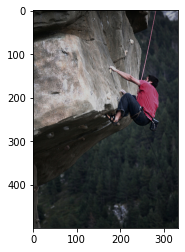

In [ ]:
img = Image.open("flickr30k_images/flickr30k_images/997722733.jpg")
plt.imshow(img)

In [ ]:
single_predict(img_caption_model_resnet50,
               test_resnet_feature['1009434119.jpg'],
               tokenizer,
               80)

'<start> a dog runs through a field <end>'

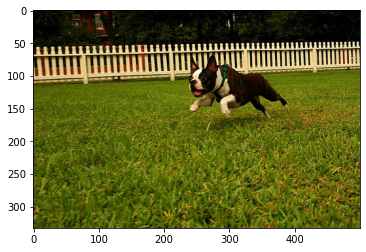

In [ ]:
img = Image.open("flickr30k_images/flickr30k_images/1009434119.jpg")
plt.imshow(img)

#Model with efficientnet features

In [ ]:
max_len = 80
vocab_size = 16681

batch_size = 128

tokenizer = pickle.load(open('tokenizer.pickle', 'rb'))

train_efficientNet_B0_feature = pickle.load(open("efficientNet_B0_train_features.pickle","rb"))

test_efficientNet_B0_feature = pickle.load(open("efficientNet_B0_test_features.pickle","rb"))

train_df = pd.read_excel("train_df_processed.xlsx")
test_df = pd.read_excel("test_df_processed.xlsx")


In [ ]:
inp1 = Input(shape=(1280,))
dp1 = Dropout(0.2)(inp1)
fc = Dense(512,activation='relu')(dp1)

inp2 = Input(shape=(max_len,))
emb = Embedding(vocab_size,256,mask_zero=True)(inp2)
dp2 = Dropout(0.2)(emb)
seq = LSTM(512)(dp2)

# decoder
decoder = add([fc,seq])
decoder = Dense(512,activation='relu')(decoder)
output = Dense(vocab_size,activation='softmax')(decoder)

img_caption_model_efficientNet_B0 = Model(inputs=[inp1,inp2],outputs=output)
img_caption_model_efficientNet_B0.compile('adam',loss='categorical_crossentropy')

In [ ]:

epoch = 100
train_steps = train_df.shape[0] // batch_size
test_steps = test_df.shape[0] // batch_size
checkpoint_path = "/content/drive/MyDrive/Portfolio/image_caption/efficientnet_checkpoints"

train_generator = CustomDataGen(train_efficientNet_B0_feature,
                                 train_df,
                                 tokenizer,
                                 max_len,
                                 vocab_size,
                                 batch_size
                                 )

test_generator = CustomDataGen(test_efficientNet_B0_feature,
                                 test_df,
                                 tokenizer,
                                 max_len,
                                 vocab_size,
                                 batch_size
                                 )

early_stop_callback = EarlyStopping(patience=5)
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=True
                                      )

In [ ]:
history = img_caption_model_efficientNet_B0.fit(train_generator,
                                                validation_data = test_generator,
                                                epochs = epoch,
                                                batch_size = batch_size,
                                                steps_per_epoch= train_steps,
                                                validation_steps = test_steps,
                                                callbacks = [early_stop_callback,
                                                            checkpoint_callback
                                                            ]
                                                )


Epoch 1/100
993/993 [==============================] - 411s 407ms/step - loss: 4.0508 - val_loss: 3.4198
Epoch 2/100
993/993 [==============================] - 386s 389ms/step - loss: 3.1053 - val_loss: 3.1852
Epoch 3/100
993/993 [==============================] - 399s 401ms/step - loss: 2.7970 - val_loss: 3.1416
Epoch 4/100
993/993 [==============================] - 381s 383ms/step - loss: 2.5829 - val_loss: 3.1704
Epoch 5/100
993/993 [==============================] - 380s 382ms/step - loss: 2.4209 - val_loss: 3.2252
Epoch 6/100
993/993 [==============================] - 379s 382ms/step - loss: 2.2974 - val_loss: 3.2817
Epoch 7/100
993/993 [==============================] - 382s 385ms/step - loss: 2.2005 - val_loss: 3.3501
Epoch 8/100
993/993 [==============================] - 379s 381ms/step - loss: 2.1213 - val_loss: 3.4194


In [ ]:
single_predict(img_caption_model_efficientNet_B0,
               test_efficientNet_B0_feature['1009434119.jpg'],
               tokenizer,
               80)

'<start> a black and white dog is running in the grass <end>'

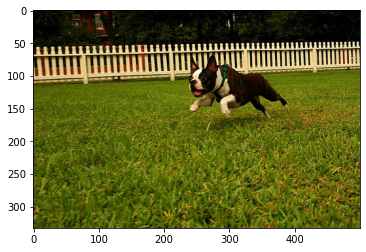

In [ ]:
img = Image.open("flickr30k_images/flickr30k_images/1009434119.jpg")
plt.imshow(img)

In [ ]:
img_caption_model_efficientNet_B0.save('/content/drive/MyDrive/Portfolio/image_caption/img_caption_model_efficientNet_B0.h5')